# Iris Automation Challenge
## Multi-label prediction for conditions in images taken by drone.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Setting up the data

- You can download whole dataset tagged which is used for this challenge from here [image1](https://firebasestorage.googleapis.com/v0/b/irischallenge/o/final%2Fimage1.jpg?alt=media), you can download them by incrementing number after image e.g. `image1.jpg to image3198.jpg`.

- Put all these images in `final` folder

In [3]:
path = './final'
path

'./final'

Labelled images obtained from Firebase is already commited in repo with name `train.csv` in `final`folder

In [4]:
df = pd.read_csv('final/train.csv')
df.head()

file                        label
0     image0.jpg                   day desert
1     image1.jpg       desert day rural sunny
2    image10.jpg   desert day sunny mountains
3   image100.jpg             desert day sunny
4  image1000.jpg             day sunny forest

Make some transformations to augment training data as we are limited in dataset

In [5]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

Get a shuffled dataset to train with labels from train.csv 

In [6]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train.csv', folder='', suffix='')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [7]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

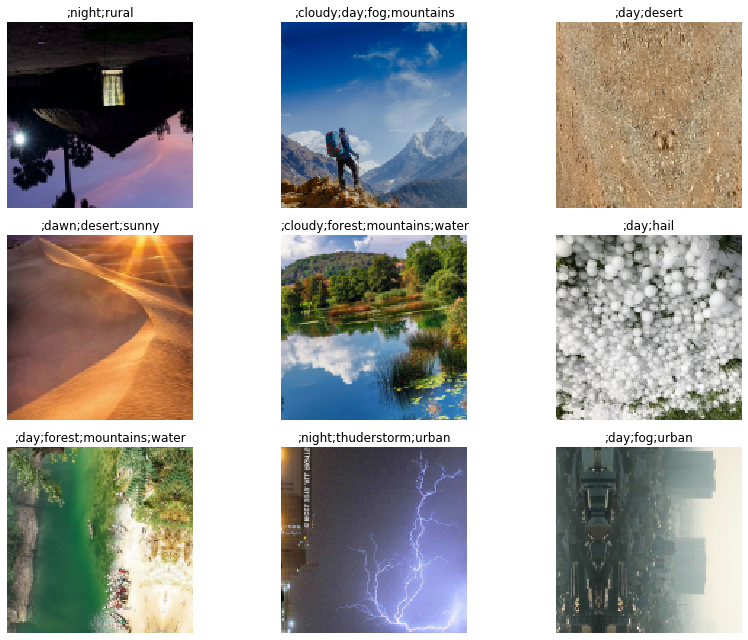

In [8]:
data.show_batch(rows=3, figsize=(12,9))

We will use already provided resnet50 architecture to train our multilabel classifier

In [9]:
arch = models.resnet50

In [10]:
acc_03 = partial(accuracy_thresh, thresh=0.3)
f_score = partial(fbeta, thresh=0.3)
learn = cnn_learner(data, arch, metrics=[acc_03, f_score])

We use the LR Finder to pick a good learning rate.

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


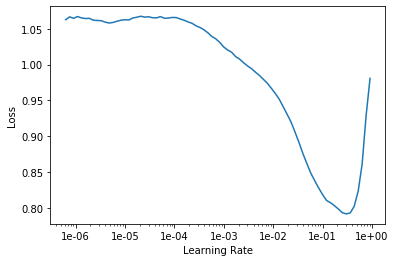

In [12]:
learn.recorder.plot()

Then we can fit the head of our network.

In [13]:
lr = 1e-01/2

In [14]:
learn.fit_one_cycle(20, slice(lr))

Lets train some more!!

In [15]:
learn.fit(10)

Save this model to resume training later.

In [16]:
learn.save('stage-1-rn50')

Exporting the model to be used in our script `detect_condition.py`

In [17]:
learn.export()

## This part is to get all predictions of all images in csv format

In [5]:
test = ImageList.from_folder('images')
len(test)

31

In [6]:
learn = load_learner('./final', test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [8]:
thresh = 0.3
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [9]:
labelled_preds[:5]

[' day sunny water',
 ' cloudy day',
 ' cloudy thuderstorm water',
 ' cloudy day forest mountains rural',
 ' day fog water']

In [10]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [11]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [12]:
df.to_csv('submission.csv', index=False)